In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import torch
from tqdm import tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import gym
from gym.spaces import Discrete, Tuple

from env_mp import MetaGames
from rmax_1 import RmaxAgent, Memory

def round_func(number, radius):
    #return (torch.round(torch.div(number, radius))) * radius
    #change made: originally: [0,3,6,9], now: [0,1,2,3]
    return (torch.round(torch.div(number, radius))) 

In [2]:
K_epochs = 4  # update policy for K epochs
inner_gamma = 0.8  #inner game discount factor
meta_gamma = 0.8   #meta game discount factor
R_max = 0.98
max_meta_epi = 300
max_meta_steps = 50
max_inner_epi = 10
max_inner_steps = 5

epsilon = 0.2
alpha = 0.4
bs = 3          #batch size (must need for mfos for good results)
radius = 5   #radius for discretization, assuming radius>1

plot_rew = torch.zeros(max_meta_epi, max_meta_steps, 2, bs).to(device)    #reward tensor for plotting purposes [episode, step, agents, batch]

# creating environment
env = MetaGames(bs, "NL", "IPD")

memory = Memory()
rmax = RmaxAgent(env, R_max, meta_gamma, inner_gamma, radius, epsilon)

In [ ]:
for episode in tqdm(range(max_meta_epi)): #for each meta-episode
    #initialise meta-state and meta-action as zeros
    meta_s = torch.zeros(env.b, env.num_actions, env.num_agents).to(device) 
    memory.states.append(meta_s)
    meta_a = torch.zeros(env.b, env.num_actions).to(device) 
    memory.actions.append(meta_a)    
    
    for step in range(max_meta_steps):    #for each meta time step
        
        for epi in range(max_inner_epi):              #for each inner episodes 
            #print("inner episode =", epi)
            #state = env.reset()   #reset environment 
            env.reset()   #reset environment 
            
            for t in range(max_inner_steps):                     #for each inner timestep
                #print("inner timestep =", t)
                if t == 0:
                    #initialised action 
                    best_action = env.init_action
                else:
                    #find action that has max Q value for current state for both agents
                    best_action = env.choose_action()   

                #run inner game according to that action, for K episodes & T timesteps, output used to be new_state, reward, done, _ 
                reward, info = env.step(best_action)  
                
                #update inner r matrix
                for i in range(env.b):
                    #env.innerr[i, state[i], best_action[0,i], 0] = reward[i] 
                    #env.innerr[i, state[i], best_action[1,i], 1] = info[i]
                    env.innerr[i, best_action[0,i], 0] = reward[i] 
                    env.innerr[i, best_action[1,i], 1] = info[i]
                    
                #update inner q matrix, another for loop since have to wait till inner r matrix gets updated    
                for i in range(env.b):    
                    #env.innerq[i, state[i], best_action[0,i], 0] = env.innerr[i, state[i], best_action[0,i], 0] + inner_gamma * torch.max(env.innerq[i, newstate[i], :, 0]) 
                    #env.innerq[i, state[i], best_action[1,i], 1] = env.innerr[i, state[i], best_action[1,i], 1] + inner_gamma * torch.max(env.innerq[i, newstate[i], :, 1])
                    env.innerq[i, best_action[0,i], 0] = env.innerr[i, best_action[0,i], 0] + inner_gamma * torch.max(env.innerq[i, :, 0]) 
                    env.innerq[i, best_action[1,i], 1] = env.innerr[i, best_action[1,i], 1] + inner_gamma * torch.max(env.innerq[i, :, 1])
                #set current state = new state
                #state = newstate  
                
        #save reward, info for plotting              
        plot_rew[episode,step,0,:] = reward
        plot_rew[episode,step,1,:] = info
        
        #meta-state = inner game Q table for all agents
        new_meta_s = round_func(env.innerq, radius)
        #meta-action = inner game Q table for our agent
        new_meta_a = round_func(env.innerq[:,:,0], radius)      
        #select meta-action that corresponds to our agent's max Q table
         
        our_REW = reward                           #meta-reward = sum of rewards of our agent in inner game of K episodes & T timesteps
        memory.rewards.append(reward)
        
        rmax.update(env, memory, meta_s, meta_a, new_meta_s)
        
        meta_s = new_meta_s
        meta_a = new_meta_a
        
#             if done:
#                 if not(reward==1):
#                     self.R[state][best_action]=-10
#                 break


  0%|                                                             | 0/300 [00:00<?, ?it/s]

episode: 0


  0%|▏                                                    | 1/300 [00:03<18:41,  3.75s/it]

episode: 1


  1%|▎                                                    | 2/300 [00:08<21:33,  4.34s/it]

episode: 2


  1%|▌                                                    | 3/300 [00:13<21:57,  4.44s/it]

episode: 3


  1%|▋                                                    | 4/300 [00:16<20:12,  4.10s/it]

episode: 4


  2%|▉                                                    | 5/300 [00:20<19:12,  3.91s/it]

episode: 5


  2%|█                                                    | 6/300 [00:24<19:23,  3.96s/it]

episode: 6


  2%|█                                                    | 6/300 [00:26<21:55,  4.47s/it]


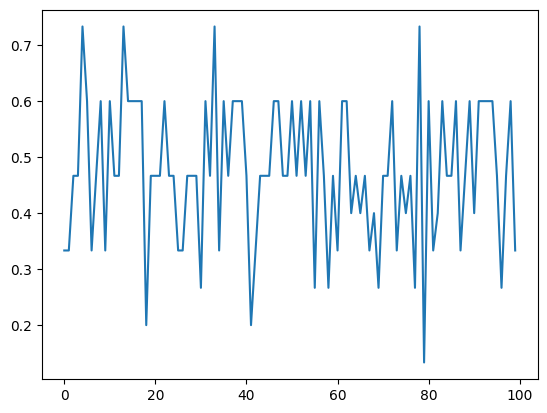

In [8]:
plot_rew_mean_batched = torch.mean(plot_rew,3)
plt.plot(plot_rew_mean_batched[:,-1,0].cpu().numpy())
